In [240]:
import numpy as np 
import matplotlib.pyplot as plt 

## Linearly seperable data 


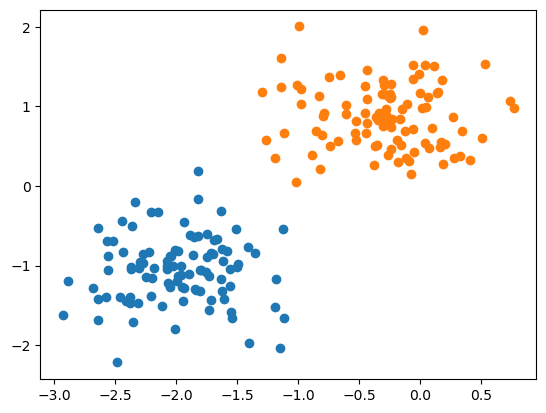

In [241]:
def generate_data(n, nr_shuffles = 0, mA =[-2, -1], 
                  mB = [-0.3, 1], sigmaA = 0.4, sigmaB = 0.4):
    n = 100
    classA = np.zeros((2, n))
    classB = np.zeros((2, n))

    classA[0, :] = np.random.randn(n) * sigmaA + mA[0]
    classA[1, :] = np.random.randn(n) * sigmaA + mA[1]

    classB[0, :] = np.random.randn(n) * sigmaB + mB[0]
    classB[1, :] = np.random.randn(n) * sigmaB + mB[1]


    # handle changing of classes
    # should it still be lienarly seperable? 
    if nr_shuffles != 0: 
        indxs = np.random.randint(0, n, nr_shuffles)
        tempA = classA[:, indxs] ; tempB = classB[:, indxs]
        classA[:, indxs] = tempB ; classB[:, indxs] = tempA

    plt.scatter(classA[0], classA[1])
    plt.scatter(classB[0], classB[1])
    plt.show()

    labels = np.zeros((classA.shape[1] * 2))
    labels[classA.shape[1]: 2*classA.shape[1]] = 1
    data = np.hstack((classA,classB))
    # shuffle: 
    shuff = np.random.permutation(labels.shape[0])
    
    data = data[:,shuff] ; labels = labels[shuff]
    return data, labels
data, labels = generate_data(100, 0)


In [242]:
from IPython.display import clear_output

def plot_data(data, labels, weight, no_bias = False):
    plt.clf()  # clear previous plot

    A = data[:,labels == 0]
    B = data[:,labels == 1]

    plt.scatter(A[0], A[1], c="blue", label="Class 0")
    plt.scatter(B[0], B[1], c="red", label="Class 1")
    if not no_bias:
        x_vals = np.linspace(min(data[0]), max(data[0]), 100)
        y_vals = -(weight[0] * x_vals + weight[2]) / weight[1]
        plt.plot(x_vals, y_vals, 'k--', label="Boundary")
    if no_bias:
        x_vals = np.linspace(min(data[0]), max(data[0]), 100)
        y_vals = -(weight[0] * x_vals) / weight[1]
        plt.plot(x_vals, y_vals, 'k--', label="Boundary")


    xlim = plt.xlim()
    plt.ylim(xlim)
    plt.legend()
    clear_output(wait=True)
    plt.show()


def plot_errors(errors, error_type = "Wrongly labeled"):

    n = len(errors)
    x_ax = np.arange(n)
    plt.plot(x_ax, errors)
    plt.xlabel("Epochs")
    if error_type == "Wrongly labeled" :
        plt.ylabel("Error")
        plt.title("Wrongly labeled")    
    else: 
        plt.ylabel("MSE")
        plt.title("MSE")
    plt.show()

## Perceptron rule


In [243]:
# init weights 
output_dim = 1
bias_vec = np.ones(output_dim)
r_weights = np.random.normal(0, 1, (2,output_dim))
W = np.vstack((r_weights, bias_vec))

def perceptron_update(W, data, labels, lr, plot=True):  # does it matter if this is seq / batch?     
    W = W.copy()
    Error_list = []
    i = 0 
    while True: 
        y_hat = W[0:2].T @ data + W[2]
        y_hat = (y_hat >= 0).astype(float) # the step func
        errors = labels - y_hat # (1,200)

        delta_w = lr * (data @ errors.T) 
        delta_b = lr * np.sum(errors) #TODO do we chnaage the bias aswell? 
        W[0:2] += delta_w
        W[2] += delta_b
        plt.clf()  # clear previous plot
        plot_data(data, labels, W)

        # Error metric: nr misclassified points 
        Error_list.append(np.sum(errors != 0))
        i += 1 
        if np.all(errors == 0): 
            print(f"converget at it {i}")
            break
        if i == 100:
            print(f"no convergance at {i} itterations")
            break
    return W, Error_list


### Delta rule 

In [244]:
output_dim = 1
bias_vec = np.ones(output_dim)
r_weights = np.random.normal(0, 1, (2,output_dim))
W = np.vstack((r_weights, bias_vec))

def delta_update(W, data, labels, lr, online=False ,plot=True, max_it = 90, stop_conv = False): 
    def all_correct(W):
        y_hat = W[0:2].T @ data + W[2]          # (1, N)
        preds = np.where(y_hat >= 0, 1, -1)      # (1, N)
        return np.all(preds == labels)
    
    # correct the labels: to (-1, 1)
    labels_plot = labels
    labels = np.where(labels == 0, -1, 1)
    W = W.copy()  # work on a copy
    Error_list = []
    Wrong_classify_list = []
    bad_temp = []

    if not online:
        for i in range(max_it):
            y_hat = W[0:2].T @ data + W[2] #(1,200)
            preds = np.where(y_hat >= 0, 1, -1)  # (1,N)
            Wrong_classify_list.append(int(np.sum(preds != labels)))    
            mse = np.mean((y_hat - labels) **2)   
            mse_deriv = (y_hat - labels) /  y_hat.shape[1]
    
            delta_w = lr * (data @ mse_deriv.T) # (2,1)
            delta_b = lr * np.mean(y_hat-labels)  #TODO do we chnaage the bias aswell? 
            W[0:2] -= delta_w
            W[2] -= delta_b
            Error_list.append(mse)
            if plot:
                plot_data(data, labels_plot, W)
            ok= all_correct(W)
            if ok and stop_conv:
                break
            elif ok:
                bad_temp.append(i)
        
    if online:
        for i in range(max_it):
            # now we do the update seqential --> we update w after every dp
            batch_error = []
            y_hat_list = []
            for t in range(data.shape[1]):
                dp = data[:,t].reshape(2,1) # needed
                y_hat = dp[0] * W[0] + dp[1] * W[1] + W[2]
                y_hat_list.append(y_hat)
                mse_no_ms = (y_hat - labels) **2
                mse_deriv = y_hat - labels[t]

                delta_w = lr * (dp * mse_deriv)
                delta_b = lr * mse_deriv
                W[0:2] -= delta_w
                W[2] -= delta_b
                batch_error.append(mse_no_ms)
            # for missed classif
            preds = np.where(np.array(y_hat_list) >= 0, 1, -1).squeeze()
            Wrong_classify_list.append(int(np.sum(preds != labels))) # for error         
            batch_error = np.array(batch_error)
            Error_list.append(np.mean(batch_error))
            plot_data(data, labels_plot, W) #! does not make sense to animate
            ok= all_correct(W)
            if ok and stop_conv:
                i = max_it
            elif ok:
                bad_temp.append(i)
    if len(bad_temp) == 0:
        bad_temp.append("Not converged")
    print(f"converged at it {bad_temp[0]}")
    return W, Error_list, Wrong_classify_list, bad_temp[0]

In [245]:
def delta_update_no_bias(W, data, labels, lr, online=False ,plot=True, max_it = 90, stop_conv = False):     
    # correct the labels: to (-1, 1)
    labels_plot = labels
    labels = np.where(labels == 0, -1, 1)
    W = W.copy()  # work on a copy
    Error_list = []
    Wrong_classify_list = []
    bad_temp = []

    if not online:
        for i in range(max_it):
            y_hat = W[0:2].T @ data 
            preds = np.where(y_hat >= 0, 1, -1)  # (1,N)
            Wrong_classify_list.append(int(np.sum(preds != labels)))    
            mse = np.mean((y_hat - labels) **2)   
            mse_deriv = (y_hat - labels) /  y_hat.shape[1]
    
            delta_w = lr * (data @ mse_deriv.T) # (2,1)
            W[0:2] -= delta_w
        
            Error_list.append(mse)
            if plot:
                plot_data(data, labels_plot, W, no_bias=True)
            bad_temp.append(i)
    if len(bad_temp) == 0:
        bad_temp.append("Not converged")
    print(f"converged at it {bad_temp[0]}")
    return W, Error_list, Wrong_classify_list, bad_temp[0]

## Experiments

Things to run: 

*p1*
1. Perceptron learning / delta online (with adjuster lr) --> study convergance 
2. delta online / delta bacth --> how "fast converge?", how sensitive to random init
3. remove bias with delta batch --> when does it converge? (classify all correctly)

*p2*

4. generate non lin seperable --> compare perceptron / delta 
5. last question

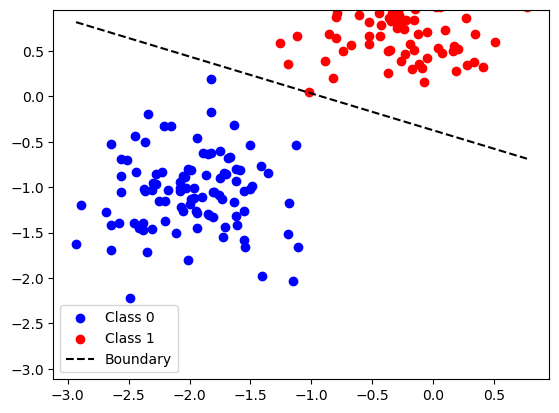

converget at it 36


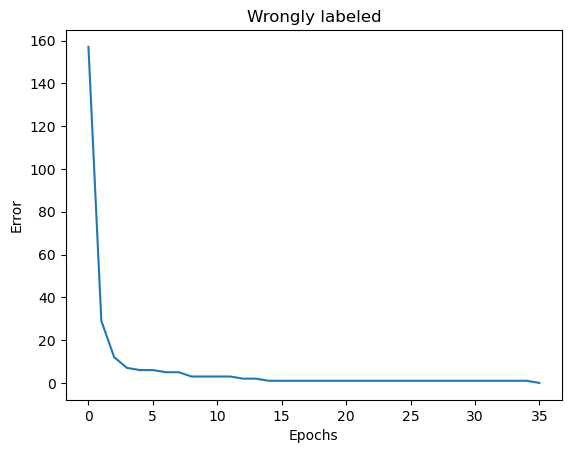

In [246]:
# 1. Perceptron learning / delta online (with adjuster lr) --> study convergance     
__, wrong_classi = perceptron_update(W,data, labels, 0.1)
plot_errors(wrong_classi)

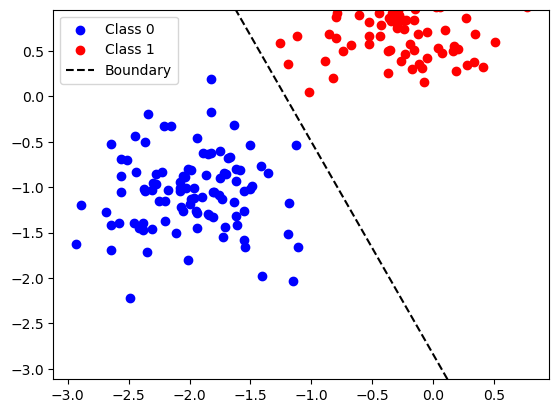

converged at it 48


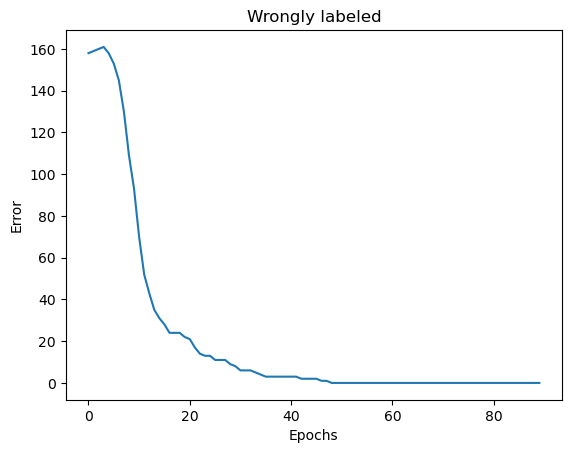

In [247]:
#1. Perceptron learning / delta online (with adjuster lr) --> study convergance 
__, __, wrong_classi2, __=delta_update(W, data, labels, 0.05 / 200, online=True)
plot_errors(wrong_classi2)

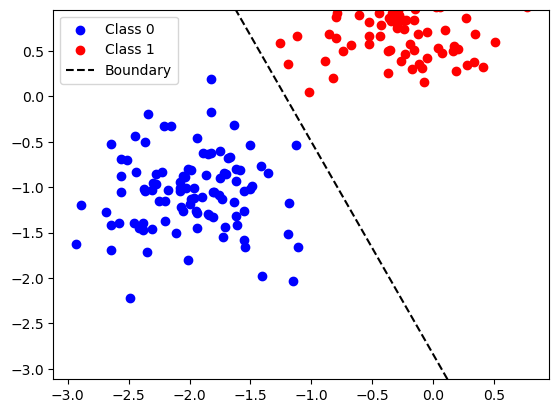

converged at it 48


In [248]:
# 2: 2. delta online / delta bacth --> how "fast converge?", how sensitive to random init

__ = delta_update(W, data, labels, 0.05 / 200, online=True)


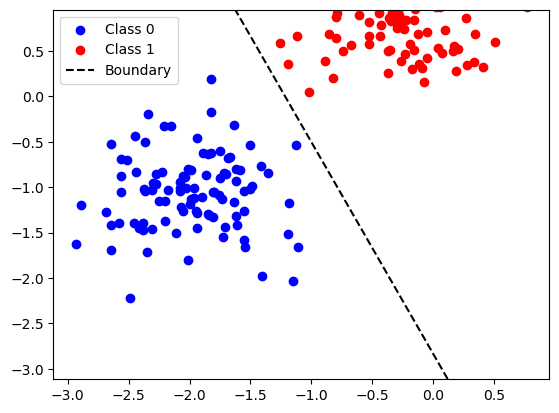

converged at it 47


In [249]:
# 2: 2. delta online / delta bacth --> how "fast converge?", how sensitive to random init

__ = delta_update(W, data, labels, 0.05, online=False)

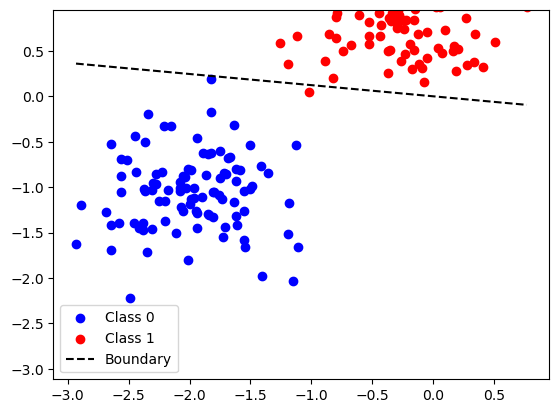

converged at it 0


In [250]:
# 3. remove bias with delta batch --> when does it converge? (classify all correctly)
__ = delta_update_no_bias(W, data, labels, 0.05, online=False)
# not here :) 

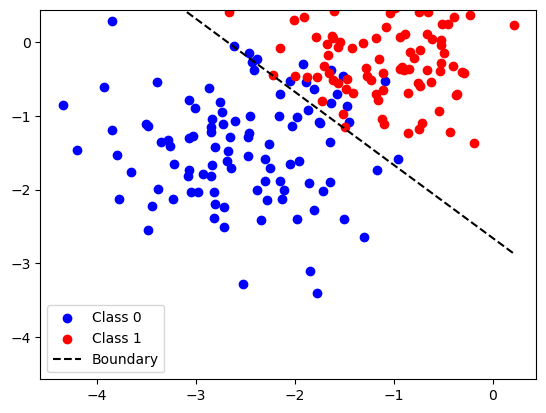

no convergance at 100 itterations


In [251]:
#4. generate non lin seperable --> compare perceptron / delta 
data_unsep, labels_unsep = generate_data(100, nr_shuffles = 0, mA =[-2.5, -1.5], 
                  mB = [-1.0, 0.0], sigmaA = 0.7, sigmaB = 0.6)
__=perceptron_update(W, data_unsep, labels_unsep, 0.05,)

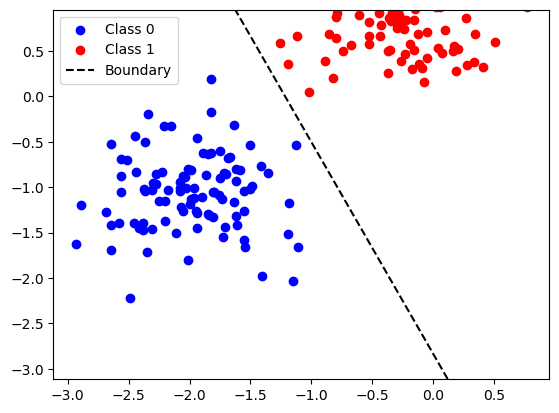

converged at it 47


In [252]:
#4. generate non lin seperable --> compare perceptron / delta 
_ = delta_update(W, data, labels, 0.05)

In [ ]:
# 5: subsampeling of data
def remove_fraction(data, labels, cls=1, frac=0.25):
    idx_cls = np.where(labels == cls)[0]
    n_remove = int(frac * len(idx_cls))
    drop = np.random.choice(idx_cls, n_remove, replace=False)

    mask = np.ones(len(labels), dtype=bool)
    mask[drop] = False

    return data[:, mask], labels[mask]

def wierd_fraction(data, labels, cls=0):
    idx_cls = np.where(labels == cls)[0]
    dp_cls = data[:, idx_cls]
    idx_pos = idx_cls[np.where(dp_cls[0, :] >= 0)[0]]  
    idx_neg = idx_cls[np.where(dp_cls[0, :] <  0)[0]] 
    
    # Currently have only pos points :( 
    n_rem_pos = int(len(idx_pos) *0.2)
    n_rem_neg = int(len(idx_neg) *0.8)
    vals_cls = data[0, idx_cls]       # first feature for class cls
    print("min:", np.min(vals_cls))
    print("max:", np.max(vals_cls))

    drop_pos = np.random.choice(idx_pos, n_rem_pos, replace=False)
    drop_neg = np.random.choice(idx_neg, n_rem_neg, replace=False)
    mask = np.ones(len(labels), dtype=bool)
    mask[drop_pos] = False
    mask[drop_neg] = False
    return data[:, mask], labels[mask]


# remove 25 % for each class
AB25_d, AB25_l = remove_fraction(data, labels, 1, 0.25)
AB25_d, AB25_l = remove_fraction(AB25_d, AB25_l, 0, 0.25)
A50_d, A50_l = remove_fraction(data, labels, 0, 0.50)
B50_d, B50_l = remove_fraction(data, labels, 1, 0.50)
wierd_d, wierd_l =wierd_fraction(data, labels, 0) # cant get this to work, dont get it



min: -2.931301057997527
max: -1.111754986704942


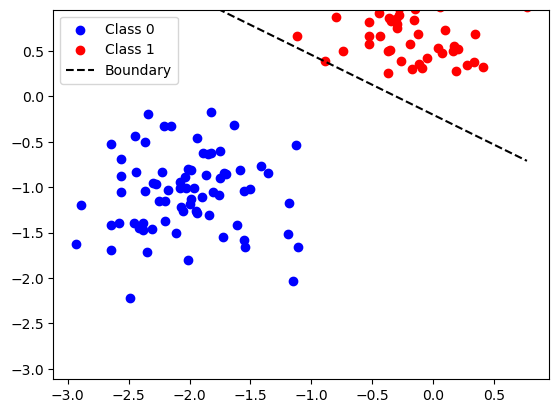

converget at it 19


In [255]:
_ =perceptron_update(W, AB25_d, AB25_l, lr = 0.1)

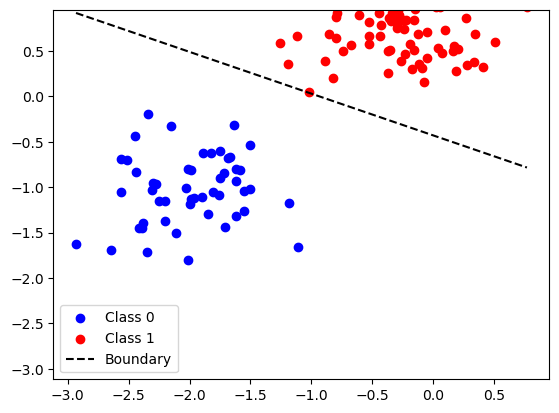

converget at it 18


In [256]:
_ =perceptron_update(W, A50_d, A50_l, lr = 0.1)

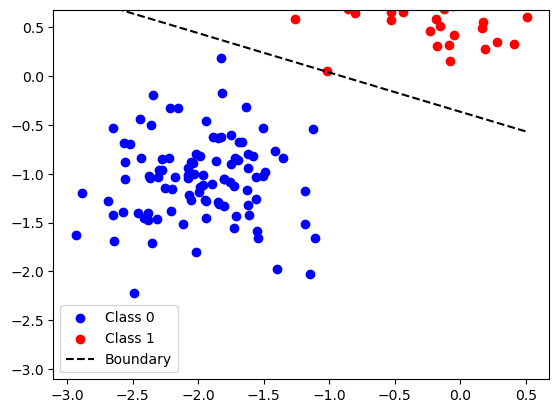

converget at it 56


In [257]:
_ =perceptron_update(W, B50_d, B50_l, lr = 0.1)